# Working with Vision

## Univeral Code Used for the Entire Notebook

Let's set up our libraries and client

In [18]:
# Get the libraries we need for the notebook
import base64  # For encoding and decoding binary data to/from ASCII
import io  # For handling byte streams
import os  # For interacting with the operating system
import requests  # For making HTTP requests
from PIL import Image as PILImage  # For image processing
from IPython.display import display, Image, Markdown, clear_output  # For displaying content in Jupyter Notebooks
from openai import OpenAI, AssistantEventHandler  # For OpenAI API and event handling
from typing_extensions import override  # For method overriding in subclasses


In [3]:
# Create an instance of the OpenAI client
client = OpenAI()

## Vision with Chat Completions

### Passing in URLs

In [11]:
# URL of the image to be analyzed
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg"

# Making a request to the OpenAI API to analyze the image
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What’s in this image?"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": image_url,
                    },
                },
            ],
        }
    ],
    max_tokens=300,
)

# Printing the response from the OpenAI API
print(response.choices[0].message.content)

# Displaying the image in the notebook
display(Image(url=image_url))


The image depicts a serene natural landscape featuring a wooden walkway that meanders through lush, green grasslands. The sky is blue with fluffy clouds, and there are trees and shrubs lining the path on either side. This scene suggests a peaceful outdoor area, likely a wetland or nature reserve, inviting visitors to explore the surroundings.


### Passing in Base64 Encoded Images (Image Files)

ChatCompletion(id='chatcmpl-9nAklBnzLs9gemZjPfFeq2iPYi79U', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The two images are related through Hedy Lamarr, the woman in the photo on the left. She was not only a famous actress but also an inventor. The diagram on the right is a representation of a frequency-hopping spread spectrum communication system that she co-invented during World War II. This technology later contributed to the development of modern wireless communication technologies like Wi-Fi and Bluetooth.', role='assistant', function_call=None, tool_calls=None))], created=1721506435, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_611b667b19', usage=CompletionUsage(completion_tokens=78, prompt_tokens=14181, total_tokens=14259))


The two images are related through Hedy Lamarr, the woman in the photo on the left. She was not only a famous actress but also an inventor. The di

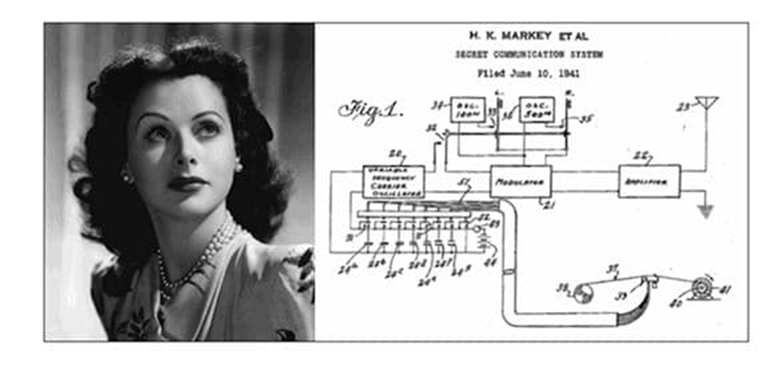

In [10]:
# Function to encode the image to base64
def encode_image(image_path):
    """Encodes an image to a base64 string."""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = "./artifacts/Hedy Lamarr and Frequency Hopping.png"

# Getting the base64 string
base64_image = encode_image(image_path)

# Payload for the API request
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "How are these two images related?"},
            {"type": "image_url", "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
            }}
        ]
    }
]

# Making a request to the OpenAI API
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    max_tokens=300,
)

# Printing the entire response from the API
print(response)
print("\n")

# Extracting and printing the message content from the response
message_content = response.choices[0].message.content
print(message_content)

# Decode the Base64 image data to binary
image_data = base64.b64decode(base64_image)

# Display the image in the notebook
display(Image(data=image_data))


## Multiple Images as Input

In [29]:
# URLs of the images to be analyzed
image_url1 = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/170207-N-WX059-0049_%2832005262704%29.jpg/537px-170207-N-WX059-0049_%2832005262704%29.jpg"
image_url2 = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/42/Dugong.JPG/640px-Dugong.JPG"

# Making a request to the OpenAI API to analyze the images
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "What is in these images? Is there any difference between them?",
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": image_url1,
                    },
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": image_url2,
                    },
                },
            ],
        }
    ],
    max_tokens=300,
)

# Printing the entire response from the API
print(response)
print("\n")

# Extracting and printing the message content from the response
message_content = response.choices[0].message.content
print(message_content)

# Display the images in the notebook
display(Image(url=image_url1))
display(Image(url=image_url2))

ChatCompletion(id='chatcmpl-9mt8zSKrtOOzOAk2dloVHeVj0UNC6', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The images depict the following:\n\n1. The first image shows two individuals underwater, dressed in scuba diving gear. One of them is holding an underwater camera.\n2. The second image shows an underwater scene featuring a marine mammal resembling a dugong or manatee swimming horizontally.\n\nThe primary difference between the images is their subject matter:\n- The first image focuses on human activity underwater, particularly scuba divers with a camera, likely engaging in underwater photography.\n- The second image centers on marine wildlife, showcasing an underwater scene with a large aquatic animal.', role='assistant', function_call=None, tool_calls=None))], created=1721438745, model='gpt-4o-2024-05-13', object='chat.completion', service_tier=None, system_fingerprint='fp_5e997b69d8', usage=CompletionUsage(completion_tokens=1

## Vision with Assistants

### Event Handler Setup for Streaming

In [4]:
class EventHandler(AssistantEventHandler):
    """Custom event handler for processing assistant events."""

    def __init__(self):
        super().__init__()
        self.results = []  # Initialize an empty list to store the results

    @override
    def on_text_delta(self, delta, snapshot):
        """Handle the event when there is a text delta (partial text)."""
        # Append the delta value (partial text) to the results list
        self.results.append(delta.value)
        # Call the method to update the Jupyter Notebook cell
        self.update_output()

    def update_output(self):
        """Update the Jupyter Notebook cell with the current markdown content."""
        # Clear the current output in the Jupyter Notebook cell
        clear_output(wait=True)
        # Join all the text fragments stored in results to form the complete markdown content
        markdown_content = "".join(self.results)
        # Display the markdown content in the Jupyter Notebook cell
        display(Markdown(markdown_content))

### Passing in URLs

In [5]:
# Create an assistant using the client library.
assistant = client.beta.assistants.create(
    model="gpt-4o",  # Specify the model to be used.
    
    instructions=""" 
        You are a helpful assistant.
    """,  # Instructions for the assistant.
    
    temperature=1,  # Set the temperature for response variability.
    top_p=1,  # Set the top_p for nucleus sampling.
)

In [7]:
# URL of the image to be analyzed
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg"

# Create a new assistant thread with an initial user message
assistant_thread = client.beta.threads.create(
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "What is in this image?",
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": image_url,
                    },
                },
            ],
        },
    ]
)



In [9]:
# Stream the assistant's response
with client.beta.threads.runs.stream(
    thread_id=assistant_thread.id,  # Specify the thread ID.
    assistant_id=assistant.id,  # Specify the assistant ID.
    instructions="""
    You are a helpful assistant.
    """,  # Provide instructions to the assistant.
    event_handler=EventHandler(),  # Use the custom event handler for processing events.
) as stream:
    stream.until_done()  # Continue streaming until the assistant has finished responding.
    
# Display the images in the notebook
display(Image(url=image_url))

This image depicts a serene natural landscape featuring a wooden boardwalk that extends into the distance, surrounded by lush green grass and vegetation. The sky above is a brilliant blue with scattered white clouds. The scene suggests a peaceful, possibly rural or nature reserve area, perfect for a walk or enjoying the outdoors.

### Passing in a File

In [13]:
# Path to your image
image_path = "./artifacts/Hedy Lamarr and Frequency Hopping.png"

# Upload the image file to the client for vision-related tasks
image_file = client.files.create(
    file=open(image_path, "rb"),
    purpose="vision"
)



In [15]:
# Create a new assistant thread with an initial user message
assistant_thread = client.beta.threads.create(
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "How are these two images related?"
                },
                {
                    "type": "image_file",
                    "image_file": {
                        "file_id": image_file.id
                    }
                }
            ]
        }
    ]
)



The two images are related through Hedy Lamarr, who is shown in the left image. Hedy Lamarr, while widely known as a famous Hollywood actress, was also an accomplished inventor. The right image is a diagram from a patent for a "Secret Communication System" that she co-invented with composer George Antheil in 1941.

This invention was a frequency-hopping spread spectrum technology designed to prevent the jamming of radio-controlled torpedoes during World War II. Their system used synchronized frequency changes to create a secure communication channel, which was difficult for enemies to intercept or jam. Although the technology was not adopted at the time, it laid the groundwork for modern wireless communication technologies, including Wi-Fi, Bluetooth, and GPS.

The images together illustrate Hedy Lamarr's significant contributions to both the entertainment industry and the field of communication technology.

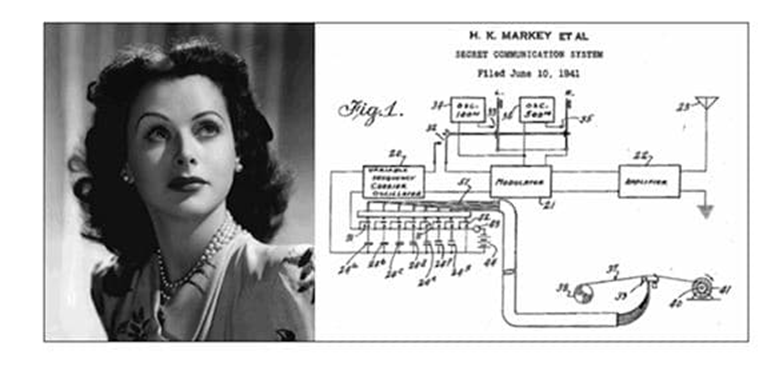

In [22]:
# Stream the assistant's response
with client.beta.threads.runs.stream(
    thread_id=assistant_thread.id,  # Specify the thread ID.
    assistant_id=assistant.id,  # Specify the assistant ID.
    instructions="""
    You are a helpful assistant.
    """,  # Provide instructions to the assistant.
    event_handler=EventHandler(),  # Use the custom event handler for processing events.
) as stream:
    stream.until_done()  # Continue streaming until the assistant has finished responding.
    
# Retrieve the file content using the file ID
image_data = client.files.content(image_file.id)

# Create an image object from the binary data
image = PILImage.open(io.BytesIO(image_data.content))

# Display the image
rgb_image = image.convert('RGB')
display(rgb_image)

### Multiple Images as Input

In [27]:
# URL of the first image to be analyzed
image_url1 = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/170207-N-WX059-0049_%2832005262704%29.jpg/537px-170207-N-WX059-0049_%2832005262704%29.jpg"

# Path to your local image
image_path = "./artifacts/Poker Hand.png"

# Upload the local image file to the client for vision-related tasks
image_file = client.files.create(
    file=open(image_path, "rb"),
    purpose="vision"
)

# Create a new assistant thread with an initial user message
assistant_thread = client.beta.threads.create(
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "What is in these images?"
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": image_url1
                    }
                },
                {
                    "type": "image_file",
                    "image_file": {
                        "file_id": image_file.id
                    }
                }
            ]
        }
    ]
)


The first image shows two scuba divers underwater. One of them is holding a large underwater camera in front of his face, suggesting that he is photographing or filming. Both divers are equipped with diving gear including masks, regulators, and buoyancy control devices.

The second image depicts a poker game in progress. The player's hand contains an Ace of Spades and a Jack of Spades, making a strong hand (a potential blackjack in another game, but here it might suggest a potential flush or straight in poker). On the table, three cards are shown face up: the Ace of Hearts, Nine of Clubs, and Six of Clubs. There is also a blue poker chip visible on the table.

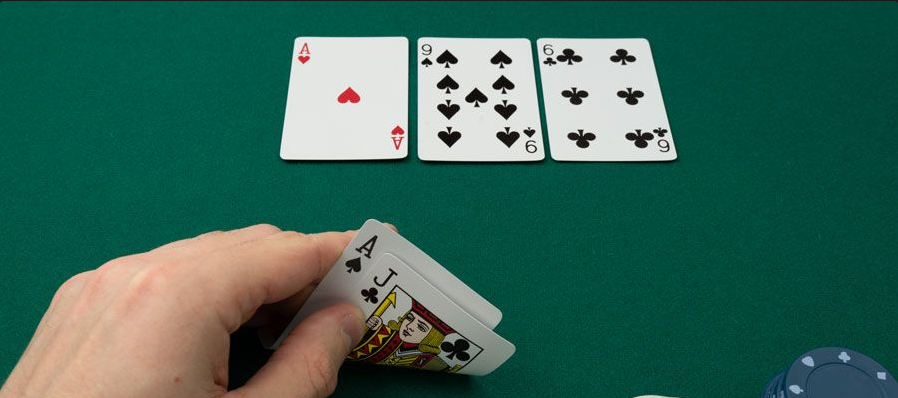

In [28]:
# Stream the assistant's response
with client.beta.threads.runs.stream(
    thread_id=assistant_thread.id,  # Specify the thread ID.
    assistant_id=assistant.id,  # Specify the assistant ID.
    instructions="""
    You are a helpful assistant.
    """,  # Provide instructions to the assistant.
    event_handler=EventHandler(),  # Use the custom event handler for processing events.
) as stream:
    stream.until_done()  # Continue streaming until the assistant has finished responding.
    
# Display the image with the URL
display(Image(url=image_url1))
    
# Display the image uploaded as a file
# Retrieve the file content using the file ID
image_data = client.files.content(image_file.id)

# Create an image object from the binary data
image = PILImage.open(io.BytesIO(image_data.content))

# Display the image
rgb_image = image.convert('RGB')
display(rgb_image)